# Comparison of Clustering Algorithms

Comparison of two clustering Algorithms
1. HierarchicalClustering.
2. KMeansClustering.

we will compare these two clustering methods in three areas:

<b>Efficiency</b> - Which method computes clusterings more efficiently?<br>
<b>Automation</b> - Which method requires less human supervision to generate reasonable clusterings?<br>
<b>Quality</b> - Which method generates clusterings with less error?<br>

In [19]:
## import necessary  library 
import random
from matplotlib import pyplot as plt
import matplotlib

In [2]:
"""
Cluster class for Module 3
"""
import math

class Cluster:
    """
    Class for creating and merging clusters of counties
    """
    
    def __init__(self, fips_codes, horiz_pos, vert_pos, population, risk):
        """
        Create a cluster based the models a set of counties' data
        """
        self._fips_codes = fips_codes
        self._horiz_center = horiz_pos
        self._vert_center = vert_pos
        self._total_population = population
        self._averaged_risk = risk
        
        
    def __repr__(self):
        """
        String representation assuming the module is "alg_cluster".
        """
        rep = "alg_cluster.Cluster("
        rep += str(self._fips_codes) + ", "
        rep += str(self._horiz_center) + ", "
        rep += str(self._vert_center) + ", "
        rep += str(self._total_population) + ", "
        rep += str(self._averaged_risk) + ")"
        return rep


    def fips_codes(self):
        """
        Get the cluster's set of FIPS codes
        """
        return self._fips_codes
    
    def horiz_center(self):
        """
        Get the averged horizontal center of cluster
        """
        return self._horiz_center
    
    def vert_center(self):
        """
        Get the averaged vertical center of the cluster
        """
        return self._vert_center
    
    def total_population(self):
        """
        Get the total population for the cluster
        """
        return self._total_population
    
    def averaged_risk(self):
        """
        Get the averaged risk for the cluster
        """
        return self._averaged_risk
   
        
    def copy(self):
        """
        Return a copy of a cluster
        """
        copy_cluster = Cluster(set(self._fips_codes), self._horiz_center, self._vert_center,
                               self._total_population, self._averaged_risk)
        return copy_cluster


    def distance(self, other_cluster):
        """
        Compute the Euclidean distance between two clusters
        """
        vert_dist = self._vert_center - other_cluster.vert_center()
        horiz_dist = self._horiz_center - other_cluster.horiz_center()
        return math.sqrt(vert_dist ** 2 + horiz_dist ** 2)
        
    def merge_clusters(self, other_cluster):
        """
        Merge one cluster into another
        The merge uses the relatively populations of each
        cluster in computing a new center and risk
        
        Note that this method mutates self
        """
        if len(other_cluster.fips_codes()) == 0:
            return self
        else:
            self._fips_codes.update(set(other_cluster.fips_codes()))
 
            # compute weights for averaging
            self_weight = float(self._total_population)                        
            other_weight = float(other_cluster.total_population())
            self._total_population = self._total_population + other_cluster.total_population()
            self_weight /= self._total_population
            other_weight /= self._total_population
                    
            # update center and risk using weights
            self._vert_center = self_weight * self._vert_center + other_weight * other_cluster.vert_center()
            self._horiz_center = self_weight * self._horiz_center + other_weight * other_cluster.horiz_center()
            self._averaged_risk = self_weight * self._averaged_risk + other_weight * other_cluster.averaged_risk()
            return self

    def cluster_error(self, data_table):
        """
        Input: data_table is the original table of cancer data used in creating the cluster.
        
        Output: The error as the sum of the square of the distance from each county
        in the cluster to the cluster center (weighted by its population)
        """
        # Build hash table to accelerate error computation
        fips_to_line = {}
        for line_idx in range(len(data_table)):
            line = data_table[line_idx]
            fips_to_line[line[0]] = line_idx
        
        # compute error as weighted squared distance from counties to cluster center
        total_error = 0
        counties = self.fips_codes()
        for county in counties:
            line = data_table[fips_to_line[county]]
            singleton_cluster = Cluster(set([line[0]]), line[1], line[2], line[3], line[4])
            singleton_distance = self.distance(singleton_cluster)
            total_error += (singleton_distance ** 2) * singleton_cluster.total_population()
        return total_error        
    
            

In [3]:
"""
slow_closest_pair(cluster_list)
fast_closest_pair(cluster_list)
closest_pair_strip(cluster_list, horiz_center, half_width)
hierarchical_clustering(cluster_list, num_clusters)
kmeans_clustering(cluster_list, num_clusters, num_iterations)

where cluster_list is a 2D list of clusters in the plane
"""

import math
#import alg_cluster    # Import Cluster class 

######################################################
# Code for closest pairs of clusters

def pair_distance(cluster_list, idx1, idx2):
    """
    Helper function that computes Euclidean distance between two clusters in a list

    Input: cluster_list is list of clusters, idx1 and idx2 are integer indices for two clusters
    
    Output: tuple (dist, idx1, idx2) where dist is distance between
    cluster_list[idx1] and cluster_list[idx2]
    """
    return (cluster_list[idx1].distance(cluster_list[idx2]), min(idx1, idx2), max(idx1, idx2))


def slow_closest_pair(cluster_list):
    """
    Compute the distance between the closest pair of clusters in a list (slow)

    Input: cluster_list is the list of clusters
    
    Output: tuple of the form (dist, idx1, idx2) where the centers of the clusters
    cluster_list[idx1] and cluster_list[idx2] have minimum distance dist.       
    """
    ans = (float("inf"),-1,-1)
    for ind_i,point_i in enumerate(cluster_list):
        for ind_j,point_j in enumerate(cluster_list):
            if ind_i != ind_j :
                distance = point_i.distance(point_j)
                if distance < ans[0]:
                    ans = (distance,ind_i,ind_j)
    return ans



def fast_closest_pair(cluster_list):
    """
    Compute the distance between the closest pair of clusters in a list (fast)

    Input: cluster_list is list of clusters SORTED such that horizontal positions of their
    centers are in ascending order
    
    Output: tuple of the form (dist, idx1, idx2) where the centers of the clusters
    cluster_list[idx1] and cluster_list[idx2] have minimum distance dist.       
    """
    num = len(cluster_list)
    if num <= 3:
        ans = slow_closest_pair(cluster_list)
    else:
        middle = num // 2
        p_left = cluster_list[:middle]
        p_right = cluster_list[middle:]
        d_left = fast_closest_pair(p_left)
        d_right = fast_closest_pair(p_right)
        ans = d_left
        if d_left[0] > d_right[0]:
            ans = (d_right[0],d_right[1]+middle,d_right[2]+middle)
        
        mid = (cluster_list[middle-1].horiz_center() + cluster_list[middle].horiz_center()) / 2
        
        res = closest_pair_strip(cluster_list,mid,ans[0])
        if res[0] < ans[0]:
            ans = res

    return ans


def closest_pair_strip(cluster_list, horiz_center, half_width):
    """
    Helper function to compute the closest pair of clusters in a vertical strip
    
    Input: cluster_list is a list of clusters produced by fast_closest_pair
    horiz_center is the horizontal position of the strip's vertical center line
    half_width is the half the width of the strip (i.e; the maximum horizontal distance
    that a cluster can lie from the center line)

    Output: tuple of the form (dist, idx1, idx2) where the centers of the clusters
    cluster_list[idx1] and cluster_list[idx2] lie in the strip and have minimum distance dist.       
    """
    #cluster_list.sort(key = lambda cluster: cluster.vert_center())
    index_set = list()
    for ind, point in enumerate(cluster_list):
        if abs(point.horiz_center()-horiz_center) < half_width :
            index_set.append(ind)
    index_set = sorted(index_set, key = lambda x: cluster_list[x].vert_center(), reverse = True)
    
    k_items = len(index_set)
    ans = (float("inf"),-1,-1)
    for u_ind in range(0,k_items-1):
        for v_ind in range(u_ind+1,min(u_ind+3,k_items-1)+1):
            distance = cluster_list[index_set[u_ind]].distance(cluster_list[index_set[v_ind]])
            if ans[0] > distance :
                ans = (distance,min(index_set[u_ind],index_set[v_ind]),max(index_set[u_ind],index_set[v_ind]))
                
    return ans
            

In [4]:
######################################################################
# Code for hierarchical clustering

def hierarchical_clustering(cluster_list, num_clusters):
    """
    Compute a hierarchical clustering of a set of clusters
    Note: the function may mutate cluster_list
    
    Input: List of clusters, integer number of clusters
    Output: List of clusters whose length is num_clusters
    """
    while len(cluster_list) > num_clusters :
        # sort list  for fast_closest_pair()
        cluster_list = sorted(cluster_list, key = lambda cluster:cluster.horiz_center())
        pair = fast_closest_pair((cluster_list))
        cluster_list[pair[1]].merge_clusters(cluster_list[pair[2]])
        cluster_list.pop(pair[2])

    return cluster_list


######################################################################
# Code for k-means clustering

    
def kmeans_clustering(cluster_list, num_clusters, num_iterations):
    """
    Compute the k-means clustering of a set of clusters
    Note: the function may not mutate cluster_list
    
    Input: List of clusters, integers number of clusters and number of iterations
    Output: List of clusters whose length is num_clusters
    """

    # position initial clusters at the location of clusters with largest populations
    cluster_list_sorted = sorted(cluster_list, key = lambda cluster:cluster.total_population(), reverse = True)
    k_cluster_center = []
    for idx in range(0,num_clusters):
        k_cluster_center.append((cluster_list_sorted[idx].horiz_center(),cluster_list_sorted[idx].vert_center()))
    
    for dummy_iter in range(1,num_iterations+1):
        #Initialize k empty sets C1, . . . , Ck;
        new_cluster = [alg_cluster.Cluster(set([]),0,0,1,0) for dummy_idx in range(0,num_clusters)]
        for index in range(0,len(cluster_list)):
            distance_list = [math.sqrt((k_cluster_center[ind_f][0] - cluster_list[index].horiz_center()) ** 2 + (k_cluster_center[ind_f][1] - cluster_list[index].vert_center()) **2 ) for ind_f in range(0,num_clusters)]
            index_min = distance_list.index(min(distance_list))	
            new_cluster[index_min].merge_clusters(cluster_list[index])
            
        for index in range(0, num_clusters):
            k_cluster_center[index] = (new_cluster[index].horiz_center(),new_cluster[index].vert_center())
    
    return new_cluster



## 1. Efficiency 

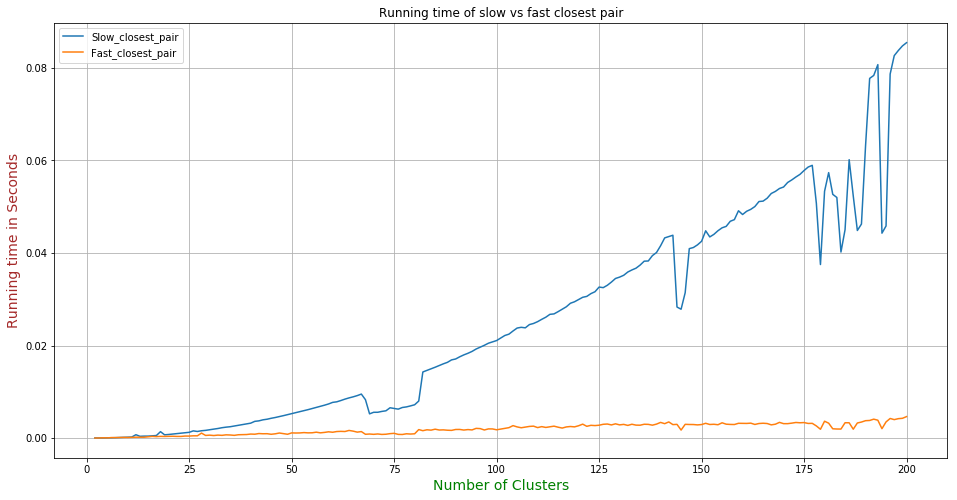

In [58]:

"""
Q1 . Comapre slow_closest_pair() and fast_closest_pair()
"""

import time


def gen_random_clusters(num_clusters):
    """
        Generate random cluster list in range [(-1,-1) to (1,1)]
    """
    cluster_list = []
    for idx in range(num_clusters):
        horiz = random.uniform(-1,1)
        vert = random.uniform(-1,1)
        cluster = Cluster(set([]),horiz,vert,1,0)
        cluster_list.append(cluster)

    return cluster_list

def wrapper(func, *args, **kwargs):
    """
        helper function for timeit
    """
    def wrapped():
        return func(*args, **kwargs)
    return wrapped

def gen_graph_data(start,end):
    slow_data = []
    fast_data = []
    num_clusters = []
    for num in range(start,end+1):
        num_clusters.append(num)
        cluster_list = gen_random_clusters(num)
        time_start = time.time()
        slow_closest_pair(cluster_list)
        time_slow = time.time() - time_start
        time_start = time.time()
        fast_closest_pair(cluster_list)
        time_fast = time.time() - time_start
        slow_data.append(time_slow)
        fast_data.append(time_fast)
    
    return num_clusters,slow_data,fast_data  


matplotlib.rc('figure', figsize=(16, 8))

num_clusters,slow_data,fast_data  = gen_graph_data(2,200)
plt.plot(num_clusters,slow_data,label = "Slow_closest_pair")
plt.plot(num_clusters,fast_data,label = "Fast_closest_pair")

plt.legend()
plt.xlabel('Number of Clusters', fontsize=14, color='Green')
plt.ylabel('Running time in Seconds', fontsize=14, color='Brown')
plt.title('Running time of slow vs fast closest pair')
#plt.show()
plt.grid(True)

plt.savefig('result.png')

In [ ]:
"""
    Q2.
"""